### Import data

In [1]:
include("importData.jl")
include("Hill.jl")
include("plot.jl")

param_lap_dde = CSV.read(joinpath("..", "data", "params_lap_DDE.csv"))
conc = [param_lap_dde[8,col] for col in 2:9]

# import G1, G2, and population data
pop, g2, g1, g2_0, g1_0 = get_data(joinpath("..", "data", "lap.csv"),
                                   joinpath("..", "data", "lap_pop.csv"));
# removing peaks from the data
for i in 1:length(conc)
    pop[:, i] = remove_peaks(pop[:, i])
    g2[:, i] = remove_peaks(g2[:, i])
    g1[:, i] = remove_peaks(g1[:, i])
end

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = get_data(::String, ::String) at importData.jl:30
└ @ Main /home/farnazm/dde/improve_fit/DrugResponseModel.jl/src/importData.jl:30
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[1]:13
└ @ Core ./In[1]:13


### Hill model, residual functions and optimization

In [20]:
# lower bound
low = [50.0, 0.001, 0.2, 0.01, 0.01, 0.001, 0.01, 20.0, 0.1, 0.01, 19.0, 0.01, 0.01, 0.001, 0.01, 0.001, 0.01]
# upper bound
high = [250.0, 0.01, 0.4, 0.04, 0.05, 0.02, 0.04, 35.0, 3.0, 0.04, 23.0, 2.0, 0.4, 0.01, 0.04, 0.04, 0.04]
# guess
guess = [50.0,0.01,0.2,0.01,0.021,0.02,0.0101,20.0286,0.1100,0.0125,21.2519,0.024374,0.0825,0.01,0.01857,0.04,0.0102]
# ,ax num of steps
num_steps=50
parameterrs, pp = optimize_hill(guess, conc, g1, g2, g1_0, g2_0, low, high, num_steps)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.74 secs, 2 evals, 1 steps, fitness=9444000672.976863861
1.46 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 1.0000), fitness=9444000672.976863861
2.26 secs, 6 evals, 3 steps, improv/step: 0.667 (last = 1.0000), fitness=8025593.114752626
2.93 secs, 8 evals, 4 steps, improv/step: 0.500 (last = 0.0000), fitness=8025593.114752626
3.45 secs, 10 evals, 5 steps, improv/step: 0.400 (last = 0.0000), fitness=2329036.103874751
4.02 secs, 12 evals, 6 steps, improv/step: 0.500 (last = 1.0000), fitness=2329036.103874751
4.58 secs, 14 evals, 7 steps, improv/step: 0.571 (last = 1.0000), fitness=2329036.103874751
5.51 secs, 16 evals, 8 steps, improv/step: 0.500 (last = 0.0000), fitness=2329036.103874751
6.31 secs, 18 evals, 9 steps, improv/step: 0.556 (last = 1.0000), fitness=1245780.623448399
7.09 

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (50) reached", 51, 1.566236967781367e9, 30.820760011672974, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed=>52382,:SearchRange=>Tuple{Float64,Float64}[(50.0, 250.0), (0.001, 0.01), (0.2, 0.4), (0.01, 0.04), (0.01, 0.05), (0.001, 0.02), (0.01, 0.04), (20.0, 35.0), (0.1, 3.0), (0.01, 0.04), (19.0, 23.0), (0.01, 2.0), (0.01, 0.4), (0.001, 0.01), (0.01, 0.04), (0.001, 0.04), (0.01, 0.04)],:TraceMode=>:compact,:Method=>:adaptive_de_rand_1_bin_radiuslimited,:MaxSteps=>50),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme=>ScalarFitnessScheme{true}(),:NumDimensions=>:NotSpecified,:PopulationSize=>50,:MaxTime=>0.0,:SearchRange=>(-1.0, 1.0),:Method=>:adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals=>100,:RngSeed=>1234,:MaxFuncEvals=>0,:SaveTrace=>false…)], 90, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(811613.085

### Plot Hill curve for all of the DDE model parameters

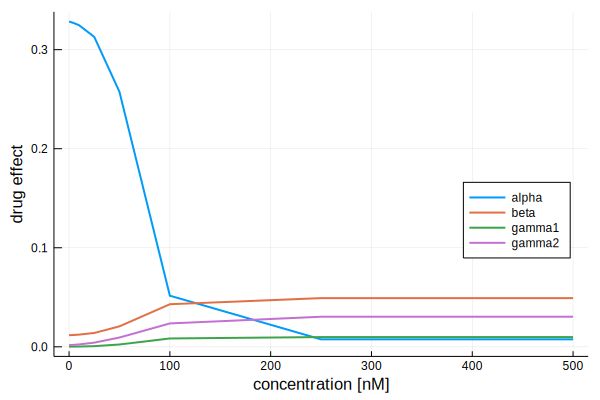

In [21]:
using Plots;

p = getDDEparams(pp, conc)
plot(conc, p[1, :], label = "alpha", linewidth = 2, xlabel = "concentration [nM]", ylabel = "drug effect")
plot!(conc, p[2, :], label = "beta", linewidth = 2, legend =:right)
plot!(conc, p[5, :], label = "gamma1", linewidth = 2)
plot!(conc, p[6, :], label = "gamma2", linewidth = 2)


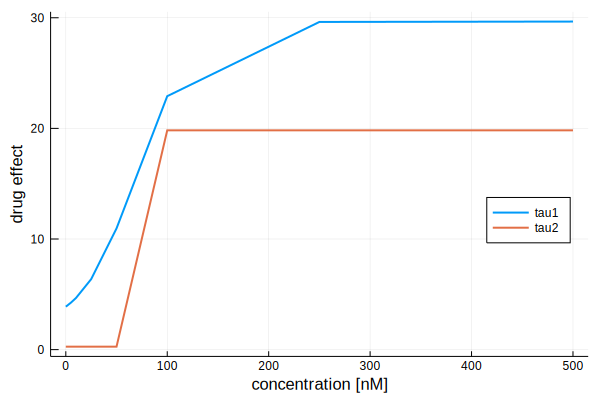

In [22]:
plot(conc, p[3, :], label = "tau1", linewidth = 2, xlabel = "concentration [nM]", ylabel = "drug effect")
plot!(conc, p[4, :], label = "tau2", linewidth = 2, legend =:right)

### Plot the data with the new set of parameters for DDE

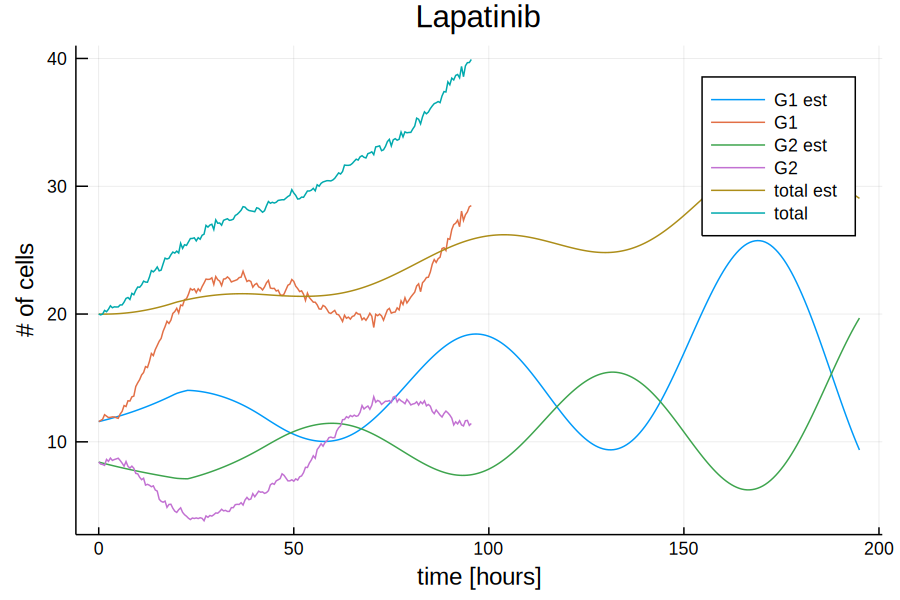

In [23]:
j = 6 # trial number
# for instance we want to plot the data and estimated for some trial 
plotIt(p[:, j], g1, g2, g1_0, g2_0, pop, j, "Lapatinib")